# **Data Mining**
### Create models to predict monthly average temperature using monthly average temperature data from January 2000 to January 2022 

# Installs

In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.1 MB/s 
     |████████████████████████████████| 9.8 MB 25.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


# Imports

In [2]:
from statsmodels.tsa.stattools import adfuller, acf
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima.utils import ndiffs
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import pmdarima as pm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
import tensorflow as tf
import random
import os

In [3]:
seed = 2022
def reset_random_seeds(seed):
  os.environ['PYTHONHASHSEED']=str(seed)
  tf.random.set_seed(seed)
  np.random.seed(seed)
  random.seed(seed)
reset_random_seeds(seed)

# Load Data

In [6]:
df = pd.read_csv('monthly.csv')
df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index('Month')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 2000-01-01 to 2022-01-01
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Max Temperature (max)     265 non-null    float64
 1   Max Temperature (avg)     265 non-null    float64
 2   Max Temperature (min)     265 non-null    float64
 3   Avg Temperature (max)     265 non-null    float64
 4   Avg Temperature (avg)     265 non-null    float64
 5   Avg Temperature (min)     265 non-null    float64
 6   Min Temperature (max)     265 non-null    float64
 7   Min Temperature (avg)     265 non-null    float64
 8   Min Temperature (min)     265 non-null    float64
 9   Dew Point (max)           265 non-null    float64
 10  Dew Point (avg)           265 non-null    float64
 11  Dew Point (min)           265 non-null    float64
 12  Precipitation (max)       265 non-null    float64
 13  Precipitation (avg)       265 non-null    floa

# EDA

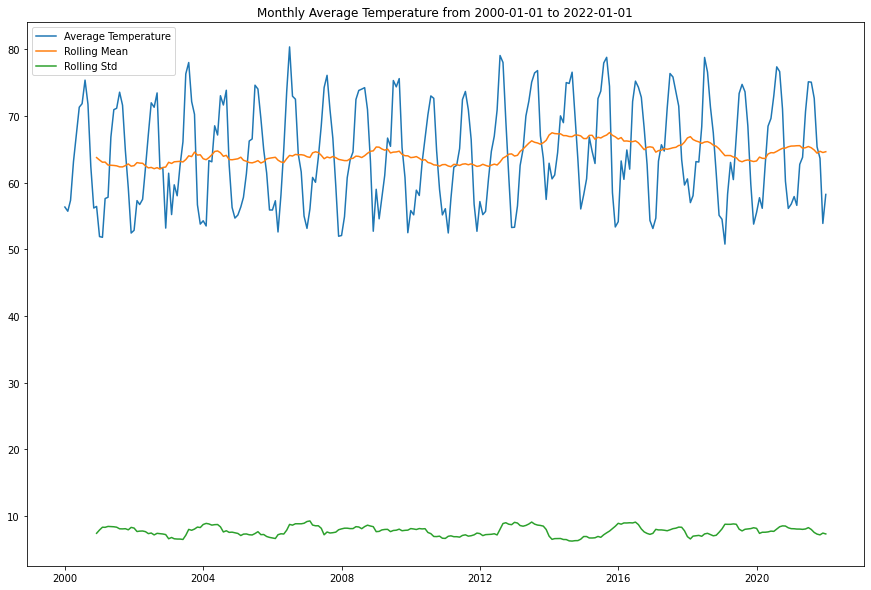

In [8]:
df['Rolling Mean'] = df['Avg Temperature (avg)'].rolling(12).mean()
df['Rolling Std'] = df['Avg Temperature (avg)'].rolling(12).std()

plt.figure(figsize=(15,10))
plt.plot(df.index, df['Avg Temperature (avg)'], label='Average Temperature')
plt.plot(df.index, df['Rolling Mean'], label='Rolling Mean')
plt.plot(df.index, df['Rolling Std'], label='Rolling Std')
plt.title("Monthly Average Temperature from 2000-01-01 to 2022-01-01")
plt.legend()
plt.show()

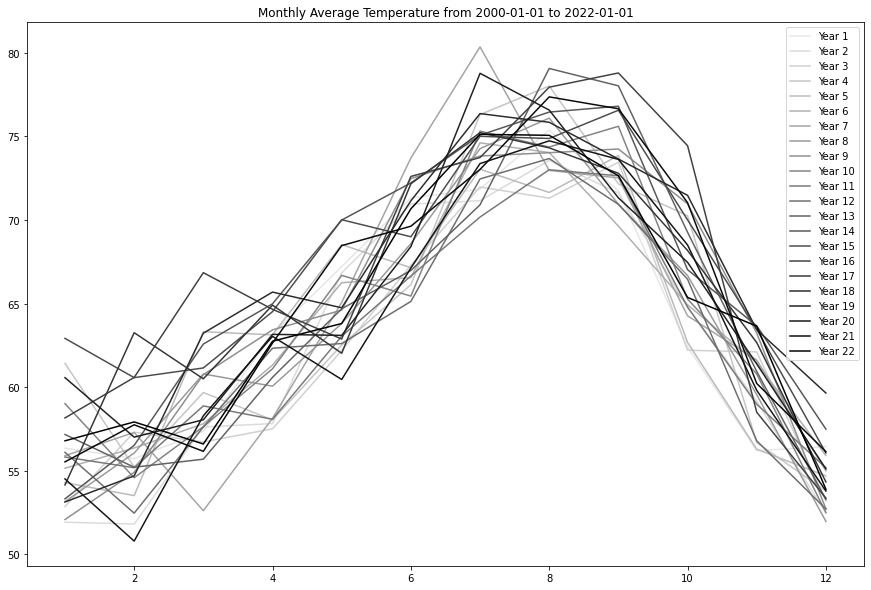

In [9]:
from matplotlib.pyplot import cm

plt.figure(figsize=(15,10))
for i, c in zip(range(1,23), cm.binary(np.linspace(0.1, 1, 22))):
  plt.plot(range(1,13), df['Avg Temperature (avg)'][(i-1)*12:i*12], label=f'Year {i}', color=c)

plt.title("Monthly Average Temperature from 2000-01-01 to 2022-01-01")
plt.legend()
plt.show()

# Data and Metrics

In [10]:
avg_train, avg_test = train_test_split(df['Avg Temperature (avg)'], test_size=0.1, shuffle=False)

In [11]:
df_train, df_test = train_test_split(df.drop(['Rolling Mean', 'Rolling Std'], axis=1), test_size=0.1, shuffle=False)

In [12]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast - actual)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

# ARIMA

### Find d

In [13]:
def adf(result, text):
  print("="*15)
  print(text)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print("="*15)

In [14]:
adf(adfuller(df['Avg Temperature (avg)'].dropna()), "Original")
adf(adfuller(df['Avg Temperature (avg)'].diff().dropna()), "1st Order Differencing")
adf(adfuller(df['Avg Temperature (avg)'].diff().diff().dropna()), "2nd Order Differencing")

Original
ADF Statistic: -2.083764
p-value: 0.251093
1st Order Differencing
ADF Statistic: -13.355032
p-value: 0.000000
2nd Order Differencing
ADF Statistic: -12.027102
p-value: 0.000000


In [15]:
## Adf Test
print(ndiffs(df['Avg Temperature (avg)'], test='adf'))

# KPSS test
print(ndiffs(df['Avg Temperature (avg)'], test='kpss'))

# PP test:
print(ndiffs(df['Avg Temperature (avg)'], test='pp'))

# seasonal differencing
print(ndiffs(df['Avg Temperature (avg)'], 12))

0
0
0
2


### Find p

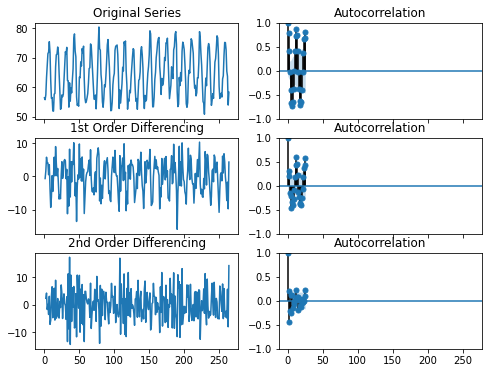

In [16]:
df_avg_temp = df.reset_index()['Avg Temperature (avg)']

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True, figsize=(8,6))
axes[0, 0].plot(df_avg_temp); axes[0, 0].set_title('Original Series')
plot_acf(df_avg_temp, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df_avg_temp.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_avg_temp.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df_avg_temp.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_avg_temp.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

### Find q

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


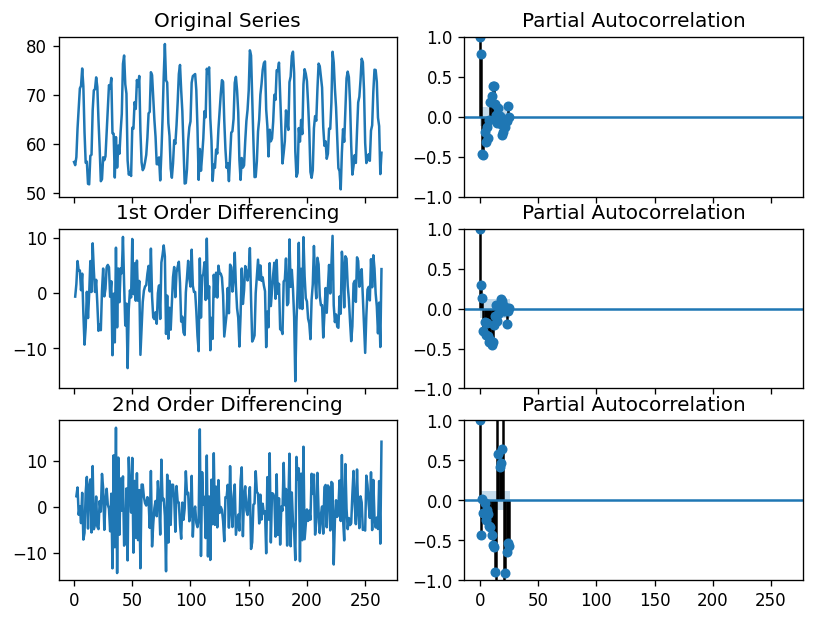

In [17]:
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True, figsize=(8,6))
axes[0, 0].plot(df_avg_temp); axes[0, 0].set_title('Original Series')
plot_pacf(df_avg_temp, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df_avg_temp.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_pacf(df_avg_temp.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df_avg_temp.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_pacf(df_avg_temp.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

## Model

In [18]:
# 1,1,2 ARIMA Model
arima = pm.arima.ARIMA(order=(1,1,2))
model_fit = arima.fit(avg_train)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  238
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -703.676
Date:                Wed, 13 Jul 2022   AIC                           1417.351
Time:                        05:28:57   BIC                           1434.692
Sample:                             0   HQIC                          1424.341
                                - 238                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0328      0.472      0.070      0.945      -0.891       0.957
ar.L1          0.0355      0.222      0.160      0.873      -0.400       0.471
ma.L1          0.2359      0.212      1.111      0.2

In [19]:
# Forecast
y_pred, confint = model_fit.predict(n_periods=len(avg_test), return_conf_int=True)
lower_series, upper_series = (pd.Series(confint[:, i], index=avg_test.index) for i in (0, 1))

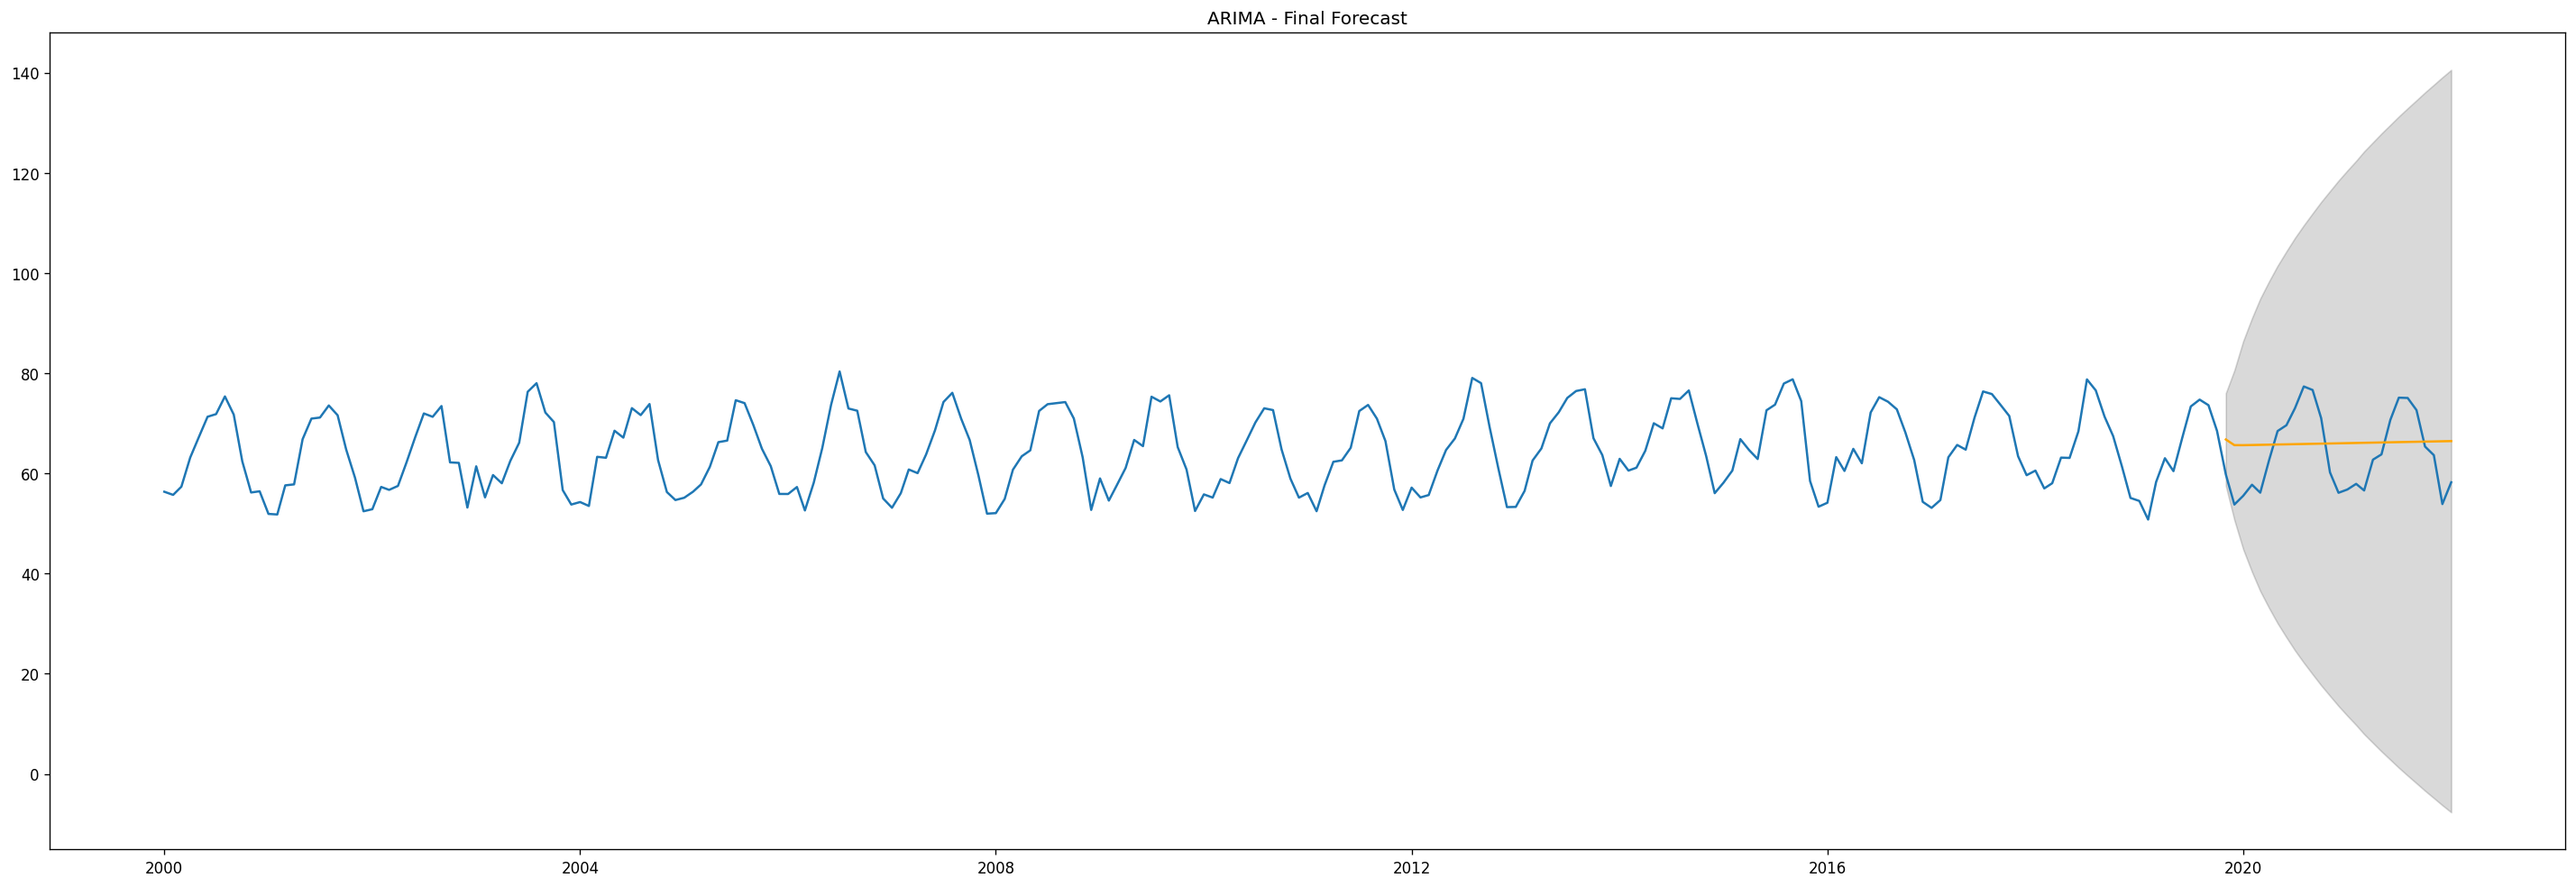

In [20]:
# Plot
plt.figure(figsize=(30,10))
plt.plot(df['Avg Temperature (avg)'])
plt.plot(pd.Series(y_pred, index=avg_test.index), color='orange')
plt.title("ARIMA - Final Forecast")
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.show()

In [21]:
arima_perf = pd.DataFrame({k:[v] for k, v in forecast_accuracy(y_pred, avg_test.values).items()}).transpose().rename({0: 'ARIMA'}, axis=1)
arima_perf

,ARIMA
mape,0.114125
me,1.960739
mae,7.104831
mpe,0.044651
rmse,7.798503
acf1,0.786309
corr,0.050632
minmax,0.103371


# Auto Arima

In [22]:
auto_arima = pm.auto_arima(avg_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1444.396, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2662.960, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2369.982, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1438.416, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1425.317, Time=0.21 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1426.169, Time=0.41 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1427.657, Time=0.18 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1295.042, Time=1.00 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1366.627, Time=1.50 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1315.238, Time=0.39 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1292.839, Time=1.84 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1277.9

In [23]:
# Forecast
n_periods = len(avg_test)
fitted, confint = auto_arima.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(avg_train.index[-1], periods=n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

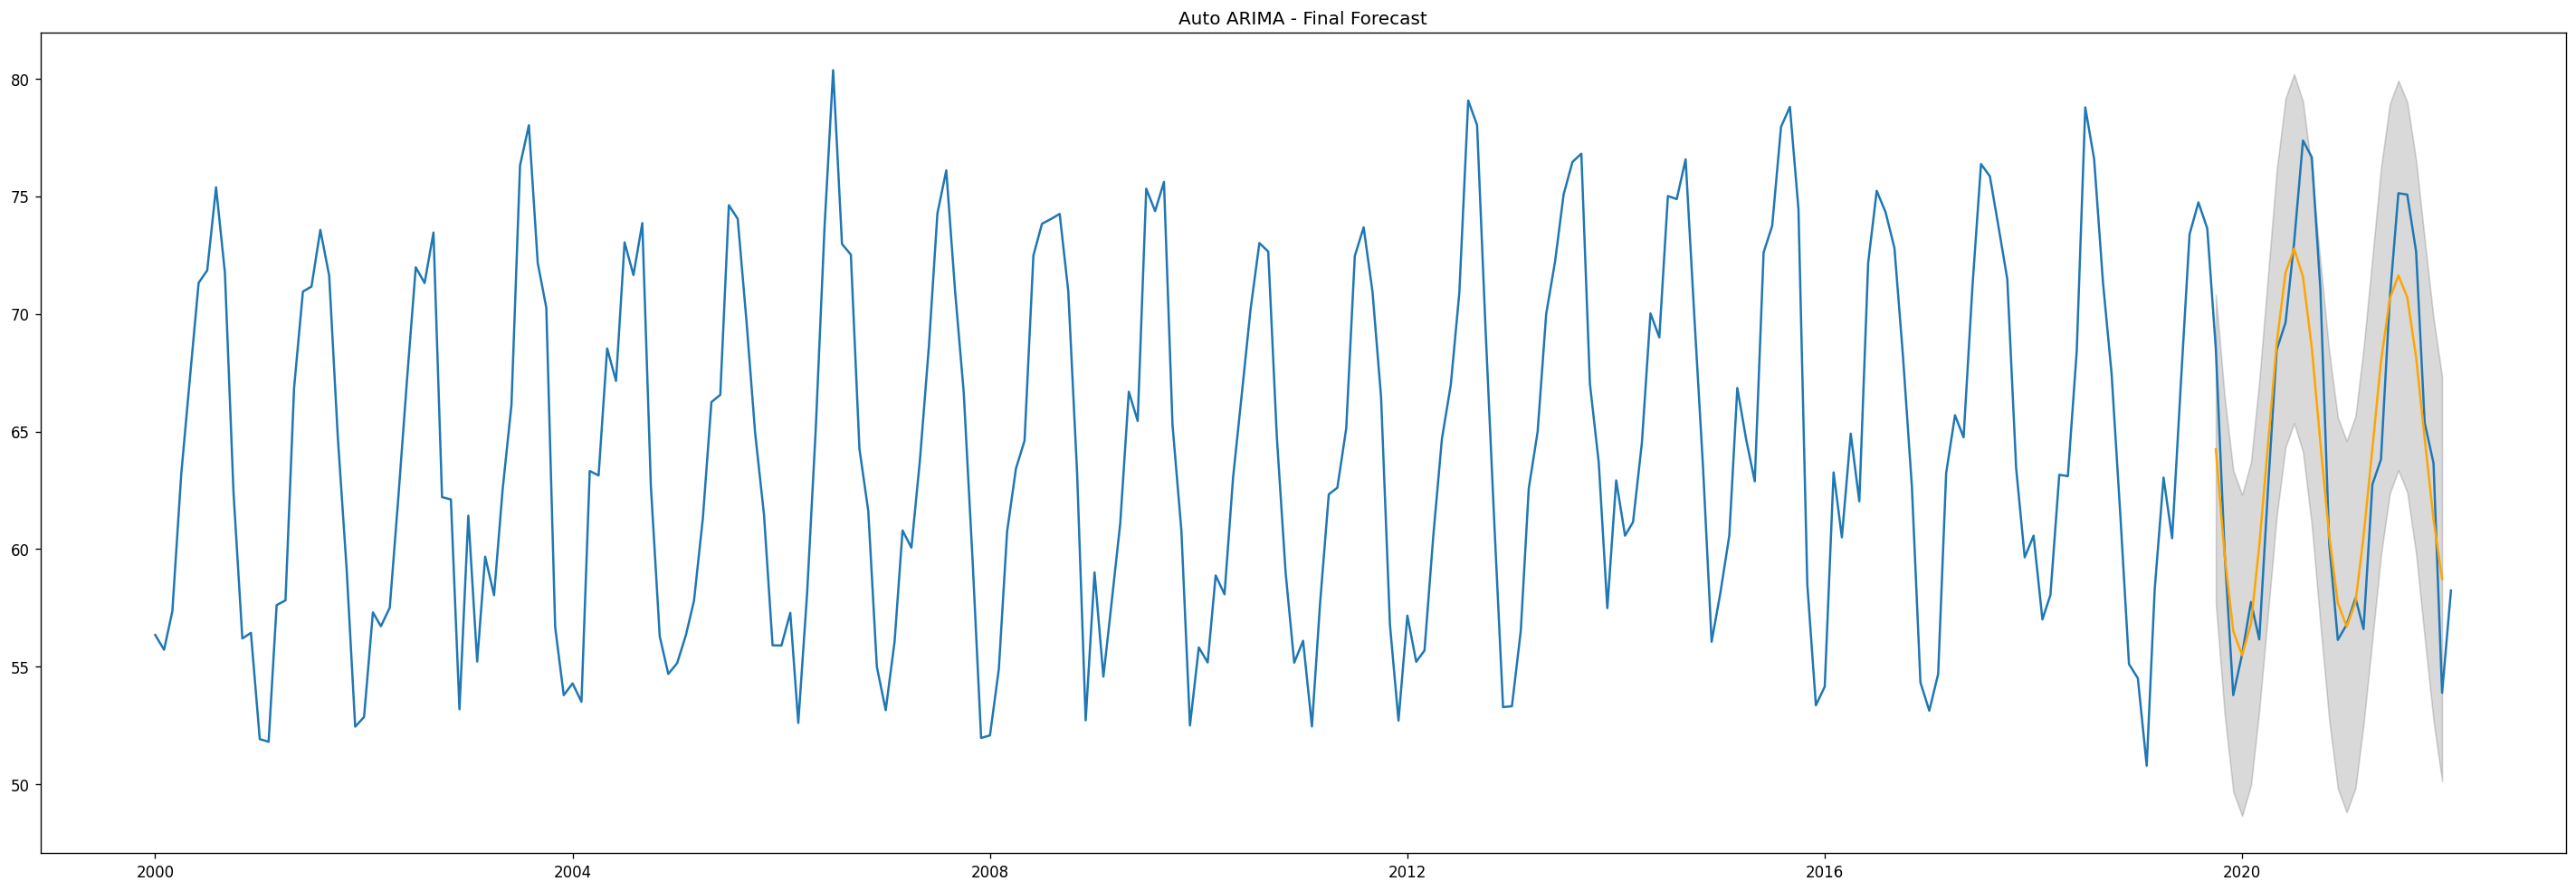

In [24]:
# Plot
plt.figure(figsize=(30,10))
plt.plot(df['Avg Temperature (avg)'])
plt.plot(fitted_series, color='orange')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Auto ARIMA - Final Forecast")
plt.show()

In [25]:
auto_arima_perf = pd.DataFrame({k:[v] for k, v in forecast_accuracy(fitted, avg_test.values).items()}).transpose().rename({0: 'Auto ARIMA'}, axis=1)
auto_arima_perf

,Auto ARIMA
mape,0.043222
me,-0.152342
mae,2.741863
mpe,0.002115
rmse,3.288330
acf1,0.445669
corr,0.920306
minmax,0.041510


# SARIMAX

Source: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [26]:
smodel = pm.auto_arima(avg_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=5, max_q=5, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.13 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1206.538, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1155.566, Time=0.51 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1204.544, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1201.066, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1138.704, Time=1.95 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.63 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.83 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1151.353, Time=1.56 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1139.470, Time=1.73 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1136.564, Time=3.02 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1156.877, Time=0.55 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=3.38 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  238
Model:             SARIMAX(3, 0, 3)x(2, 1, [], 12)   Log Likelihood                -552.507
Date:                             Wed, 13 Jul 2022   AIC                           1123.014
Time:                                     05:32:17   BIC                           1153.799
Sample:                                          0   HQIC                          1135.438
                                             - 238                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6461      0.102     -6.364      0.000      -0.845      -0.447
ar.L2          0.6628      0.117      5.664      0.000       0.433       0.892
ar.L3          0.7273      0.065     11.228      0.000       0.600       0.854
ma.L1          0.8769      0.110      7.980      0.000       0.662       1.092
ma.L2         -0.4113      0.174     -2.370      0.018      -0.751      -0.071
ma.L3         -0.7904      0.099     -8.008      0.000      -0.984      -0.597
ar.S.L12      -0.5767      0.076     -7.586      0.000      -0.726      -0.428
ar.S.L24      -0.3083      0.071     -4.350      0.000      -0.447      -0.169
sigma2         7.4948      0.801      9.355      0.000       5.925       9.065
===================================================================================
Ljung-Box (L1) (Q):                   0.81   Jarque-Bera (JB):                 1.82
Prob(Q):                              0.37   Prob(JB):                         0.40
Heteroskedasticity (H):               0.87   Skew:                             0.13
Prob(H) (two-sided):                  0.54   Kurtosis:                         2.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
# Forecast
n_periods = len(avg_test)
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(avg_train.index[-1], periods=n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

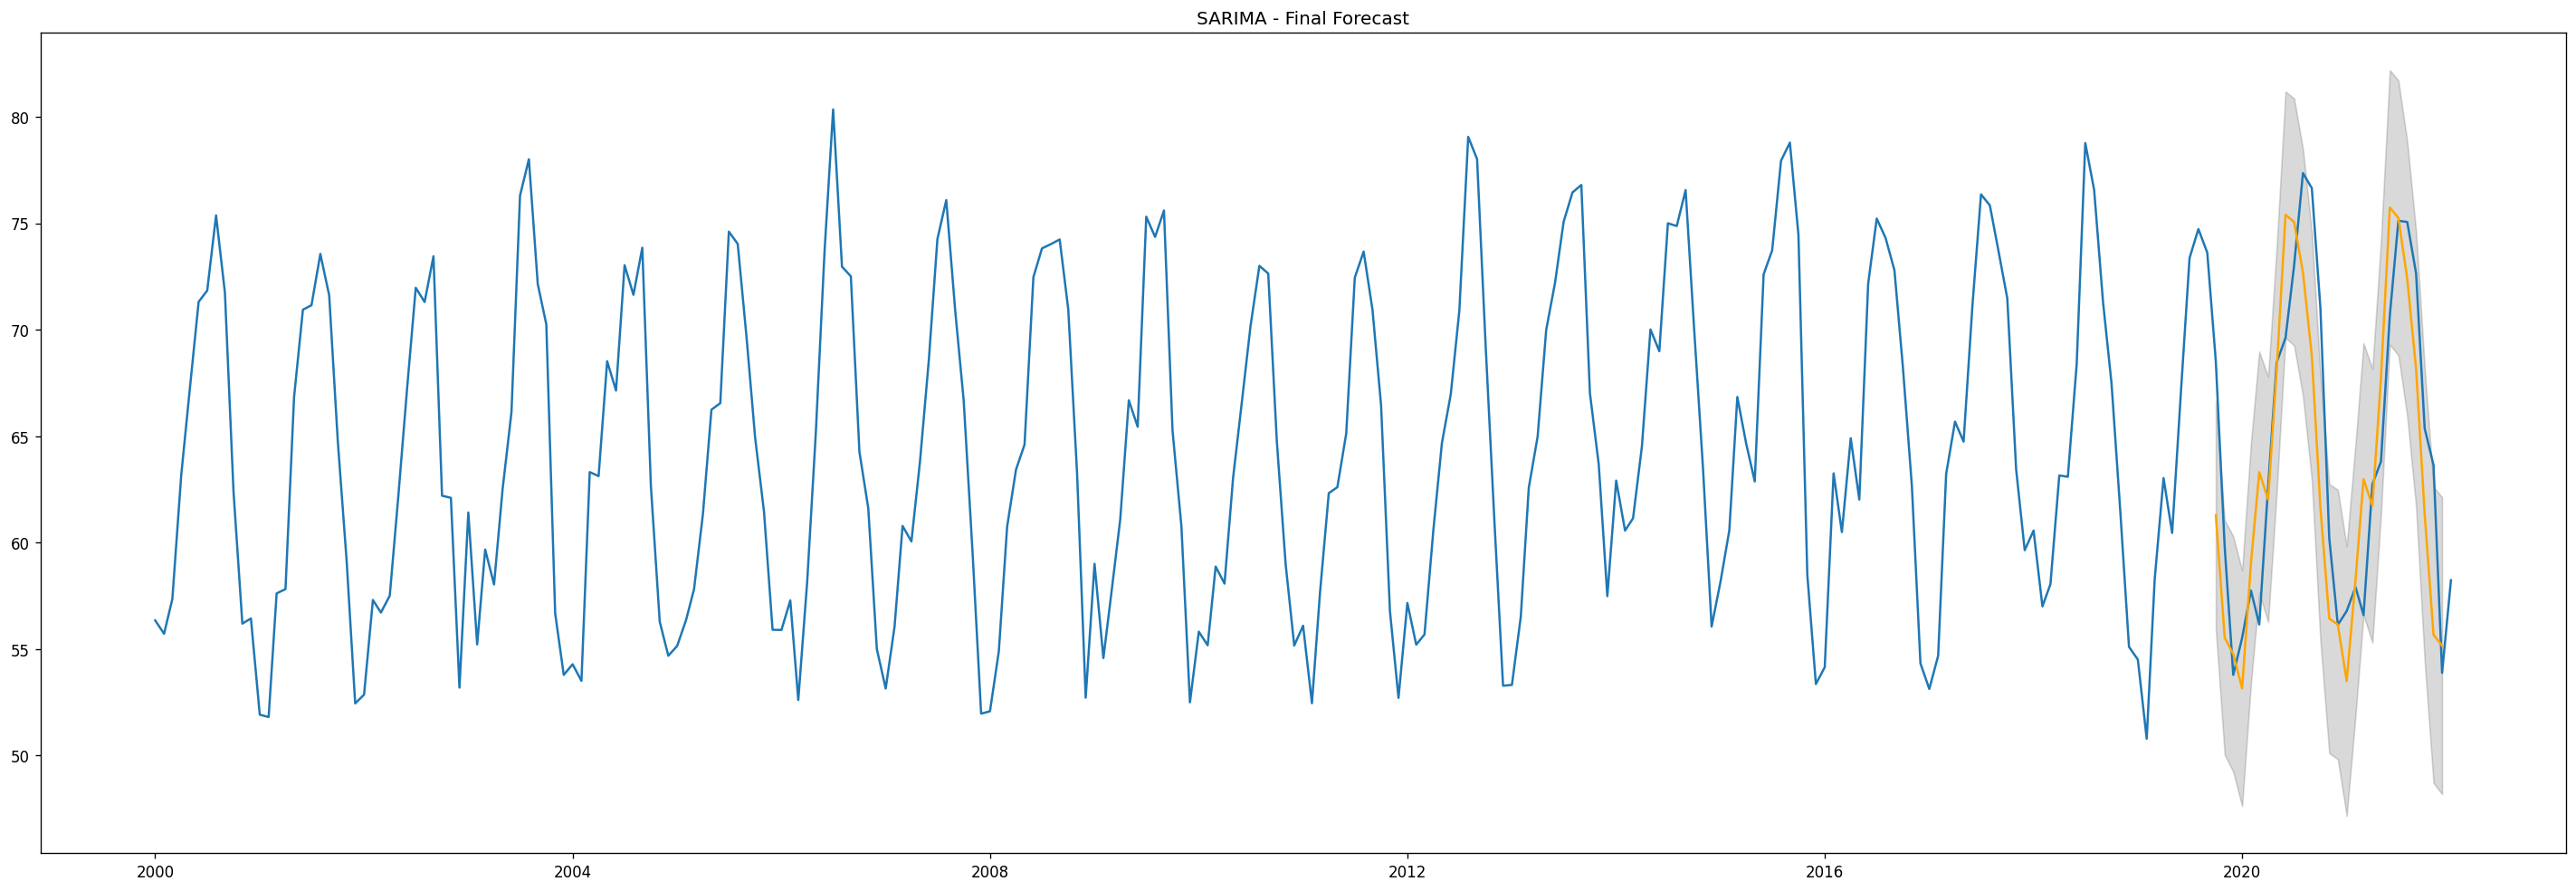

In [28]:
# Plot
plt.figure(figsize=(30,10))
plt.plot(df['Avg Temperature (avg)'])
plt.plot(fitted_series, color='orange')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast")
plt.show()

In [29]:
sarimax_perf = pd.DataFrame({k:[v] for k, v in forecast_accuracy(fitted, avg_test.values).items()}).transpose().rename({0: 'SARIMAX'}, axis=1)
sarimax_perf

,SARIMAX
mape,0.032494
me,-0.715233
mae,2.063854
mpe,-0.010183
rmse,2.547939
acf1,-0.157668
corr,0.946594
minmax,0.032138


# Univariate LSTM

Source: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [30]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [31]:
# define input sequence
raw_seq = avg_train
# choose a number of time steps
n_steps = 12
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [32]:
reset_random_seeds(seed)

In [33]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
history = model.fit(X, y, epochs=200)

Epoch 1/200
8/8 [==============================] - 2s 9ms/step - loss: 50.6573
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 25.3207
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 20.1388
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 19.4614
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 17.7338
Epoch 6/200
8/8 [==============================] - 0s 7ms/step - loss: 13.5242
Epoch 7/200
8/8 [==============================] - 0s 7ms/step - loss: 12.1533
Epoch 8/200
8/8 [==============================] - 0s 7ms/step - loss: 12.7220
Epoch 9/200
8/8 [==============================] - 0s 7ms/step - loss: 10.3615
Epoch 10/200
8/8 [==============================] - 0s 7ms/step - loss: 9.2160
Epoch 11/200
8/8 [==============================] - 0s 8ms/step - loss: 9.0987
Epoch 12/200
8/8 [==============================] - 0s 7ms/step - loss: 9.5639
Epoch 13/200
8/8 [==============================] - 

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


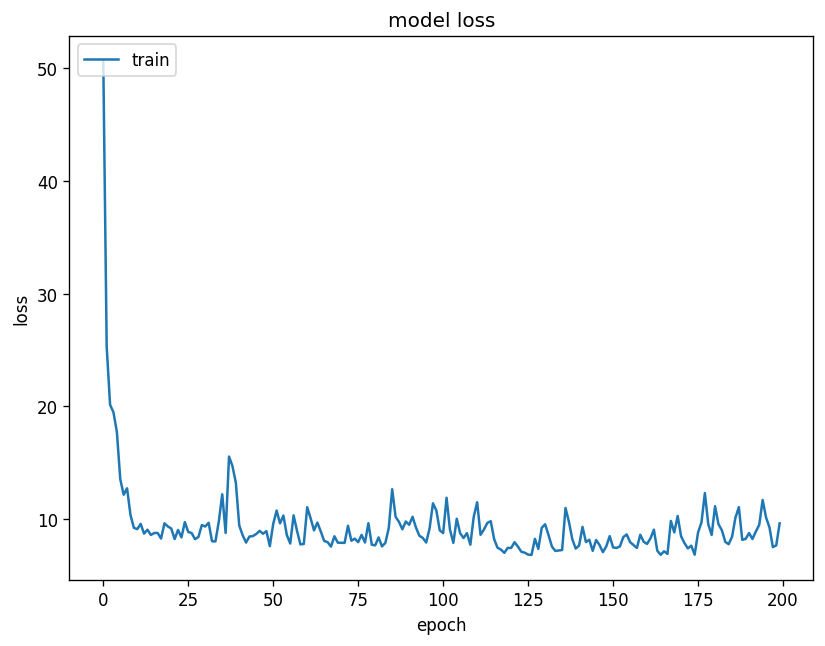

In [35]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Independent Predictions

In [36]:
x_input = pd.concat((avg_train[-n_steps:], avg_test))
X, y = split_sequence(x_input, n_steps)
X = X.reshape((X.shape[0], X.shape[1], n_features))
yhat = model.predict(X)

In [37]:
univar_ind_lstm_perf = pd.DataFrame({k:[v] for k, v in forecast_accuracy(yhat.flatten(), avg_test.values).items()}).transpose().rename({0: 'Univar Independent LSTM'}, axis=1)
univar_ind_lstm_perf

,Univar Independent LSTM
mape,0.044658
me,-2.553192
mae,2.883681
mpe,-0.038924
rmse,3.353608
acf1,-0.182469
corr,0.957988
minmax,0.044572


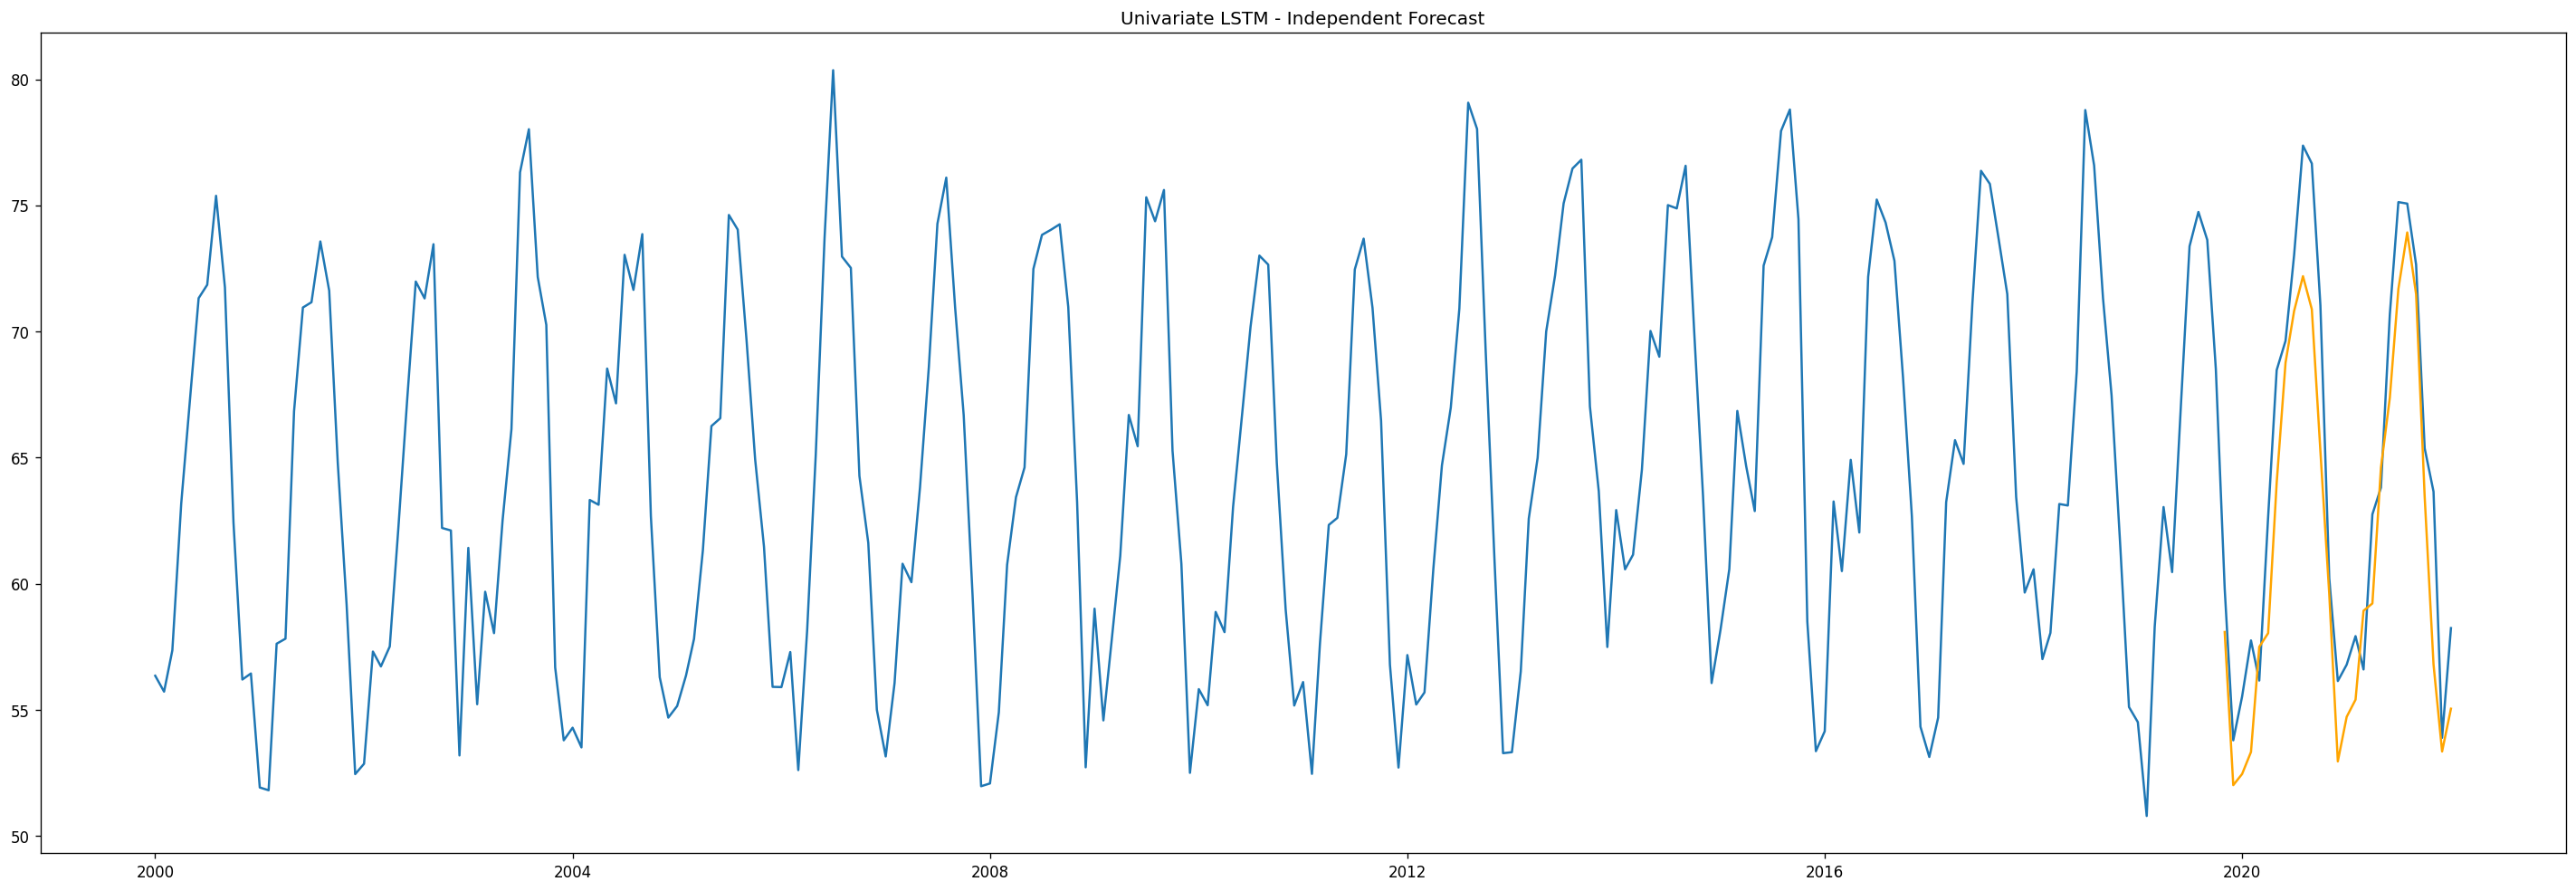

In [38]:
plt.figure(figsize=(30,10))
plt.plot(df['Avg Temperature (avg)'])
plt.plot(pd.Series(yhat.flatten(), index=avg_test.index), color='orange')

plt.title("Univariate LSTM - Independent Forecast")
plt.show()

## Dependent Predictions

In [39]:
seed_prediction = avg_train[-n_steps:]
curr_X = seed_prediction
yhat_2 = []
for i in avg_test:
  new_x = model.predict(np.array(curr_X).reshape(1, n_steps, n_features)).flatten()
  yhat_2.extend(new_x)
  curr_X = pd.concat((curr_X[-n_steps+1:], pd.Series(new_x)))

In [40]:
yhat_2 = np.array(yhat_2)

In [41]:
univar_dep_lstm_perf = pd.DataFrame({k:[v] for k, v in forecast_accuracy(yhat_2, avg_test.values).items()}).transpose().rename({0: 'Univar Dependent LSTM'}, axis=1)
univar_dep_lstm_perf

,Univar Dependent LSTM
mape,0.122977
me,-8.016990
mae,8.016990
mpe,-0.122977
rmse,8.696145
acf1,0.551945
corr,0.899918
minmax,0.122977


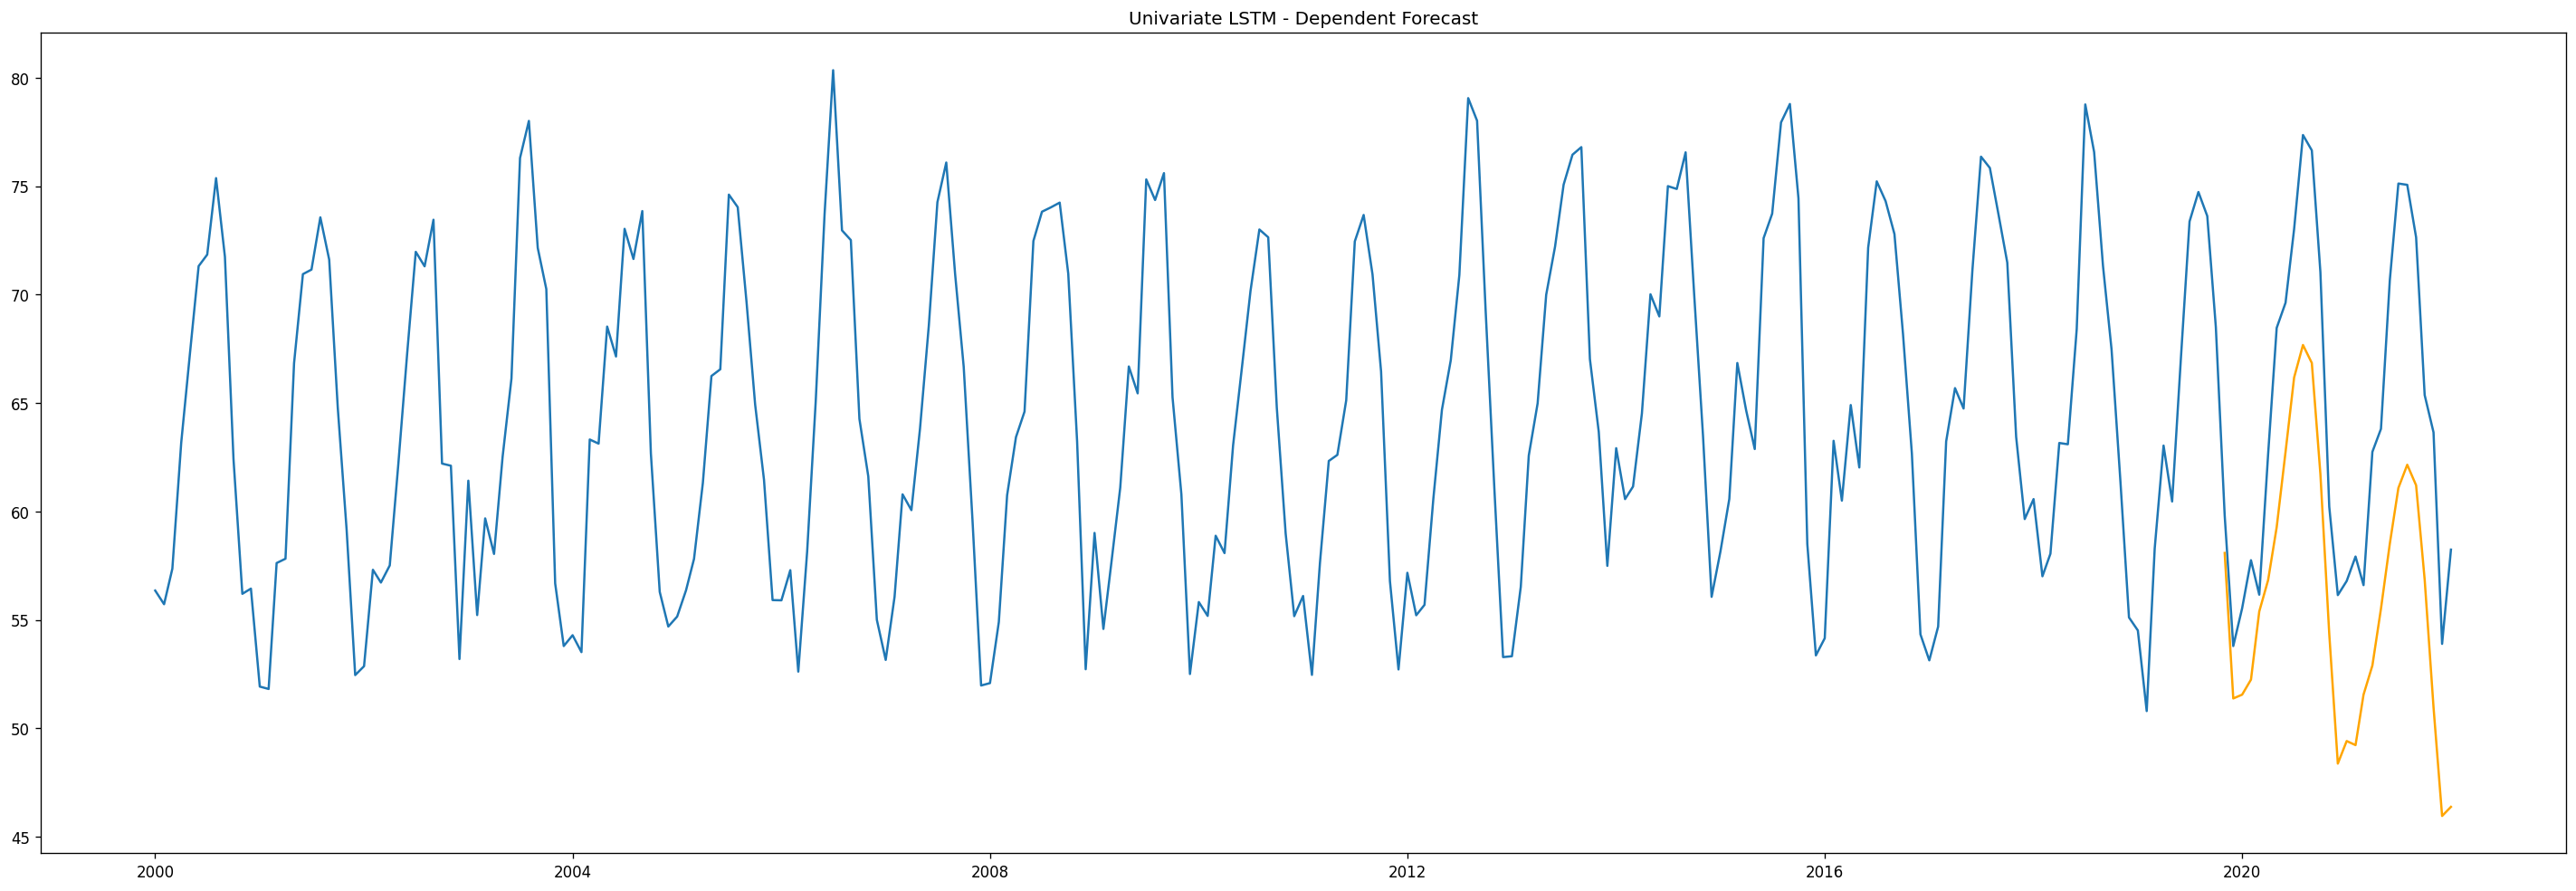

In [42]:
plt.figure(figsize=(30,10))
plt.plot(df['Avg Temperature (avg)'])
plt.plot(pd.Series(yhat_2, index=avg_test.index), color='orange')

plt.title("Univariate LSTM - Dependent Forecast")
plt.show()

# Multivariate LSTM

In [43]:
raw_seq = df_train.values
n_steps = 12
X, y = split_sequence(raw_seq, n_steps)
n_features = len(df_train.columns)
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [44]:
reset_random_seeds(seed)

In [45]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
history = model.fit(X, y, epochs=200)

Epoch 1/200
8/8 [==============================] - 1s 7ms/step - loss: 7064.4302
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 3963.8147
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 2908.4131
Epoch 4/200
8/8 [==============================] - 0s 7ms/step - loss: 2013.4805
Epoch 5/200
8/8 [==============================] - 0s 7ms/step - loss: 1811.1750
Epoch 6/200
8/8 [==============================] - 0s 7ms/step - loss: 1682.7512
Epoch 7/200
8/8 [==============================] - 0s 7ms/step - loss: 1538.0913
Epoch 8/200
8/8 [==============================] - 0s 7ms/step - loss: 1308.6982
Epoch 9/200
8/8 [==============================] - 0s 7ms/step - loss: 1014.3748
Epoch 10/200
8/8 [==============================] - 0s 7ms/step - loss: 777.6517
Epoch 11/200
8/8 [==============================] - 0s 8ms/step - loss: 573.5956
Epoch 12/200
8/8 [==============================] - 0s 8ms/step - loss: 370.4979
Epoch 13/200
8/8 [==========

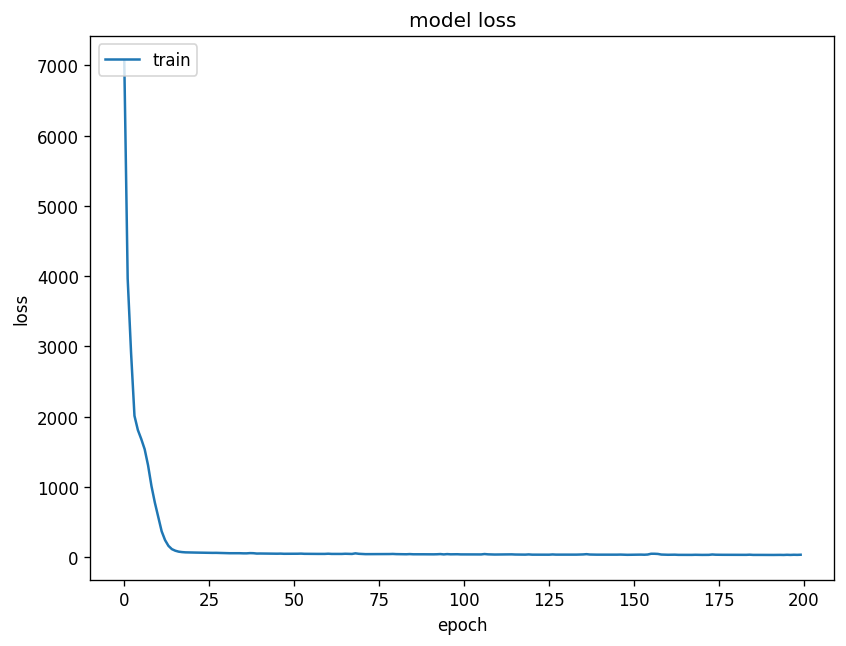

In [46]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Independent Predictions

In [47]:
x_input = pd.concat((df_train[-n_steps:], df_test))
X, y = split_sequence(x_input.values, n_steps)
yhat = model.predict(X)

In [48]:
multivar_ind_lstm_perf = pd.DataFrame({k:[v] for k, v in forecast_accuracy(yhat[:,4], y[:,4]).items()}).transpose().rename({0: 'Multivariate Independent LSTM'}, axis=1)
multivar_ind_lstm_perf

,Multivariate Independent LSTM
mape,0.090073
me,-5.683955
mae,5.752948
mpe,-0.088958
rmse,6.944481
acf1,0.473308
corr,0.872320
minmax,0.090068


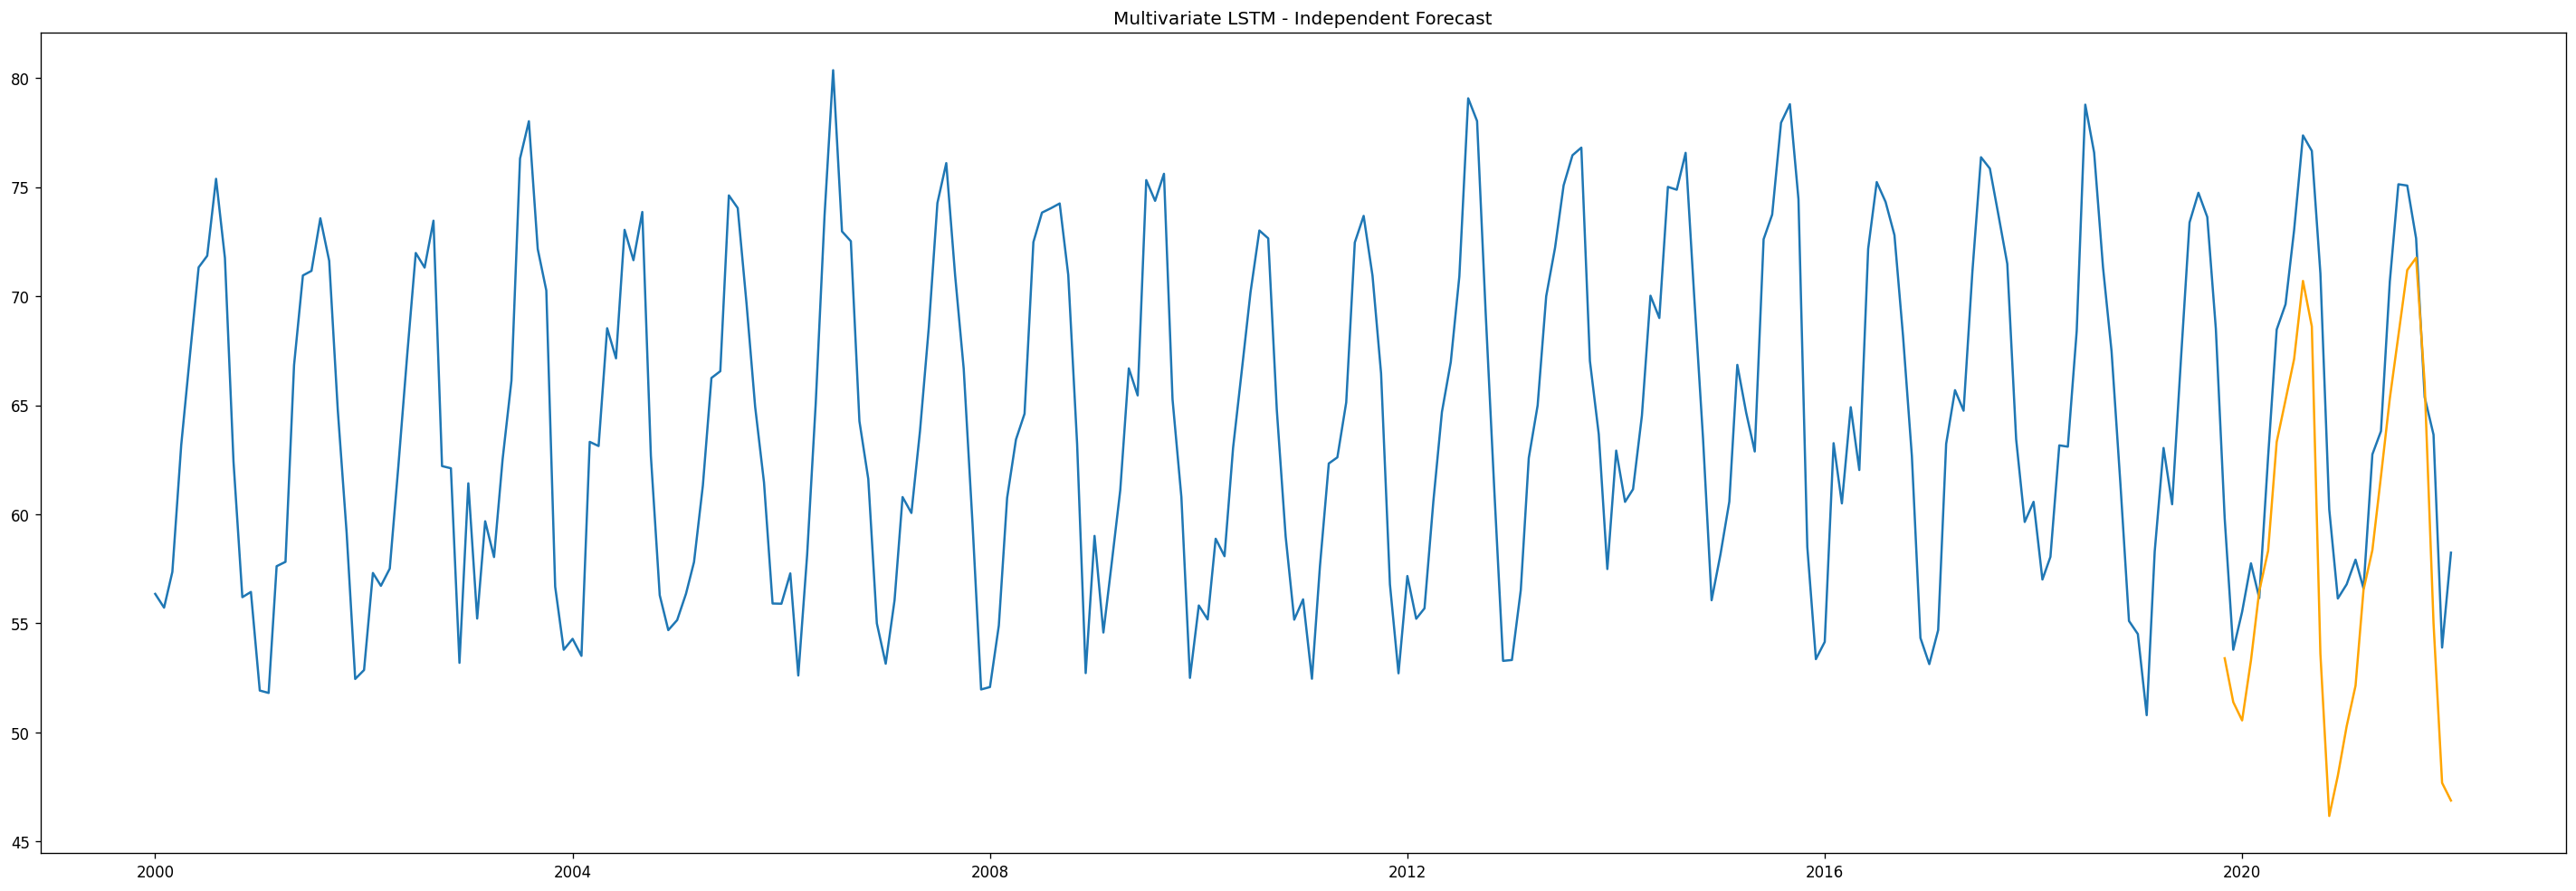

In [49]:
plt.figure(figsize=(30,10))
plt.plot(df['Avg Temperature (avg)'])
plt.plot(pd.Series(yhat[:,4], index=df_test.index), color='orange')

plt.title("Multivariate LSTM - Independent Forecast")
plt.show()

## Dependent Predictions

In [50]:
curr_X = df_train.values[-n_steps:]
yhat_3 = np.zeros((len(df_test.values), n_features))
for i in range(len(df_test.values)):
  new_x = model.predict(np.array(curr_X).reshape(1, n_steps, n_features)).reshape(1, n_features)
  yhat_3[i,:] = new_x
  curr_X = np.vstack((curr_X[-n_steps+1:], new_x))

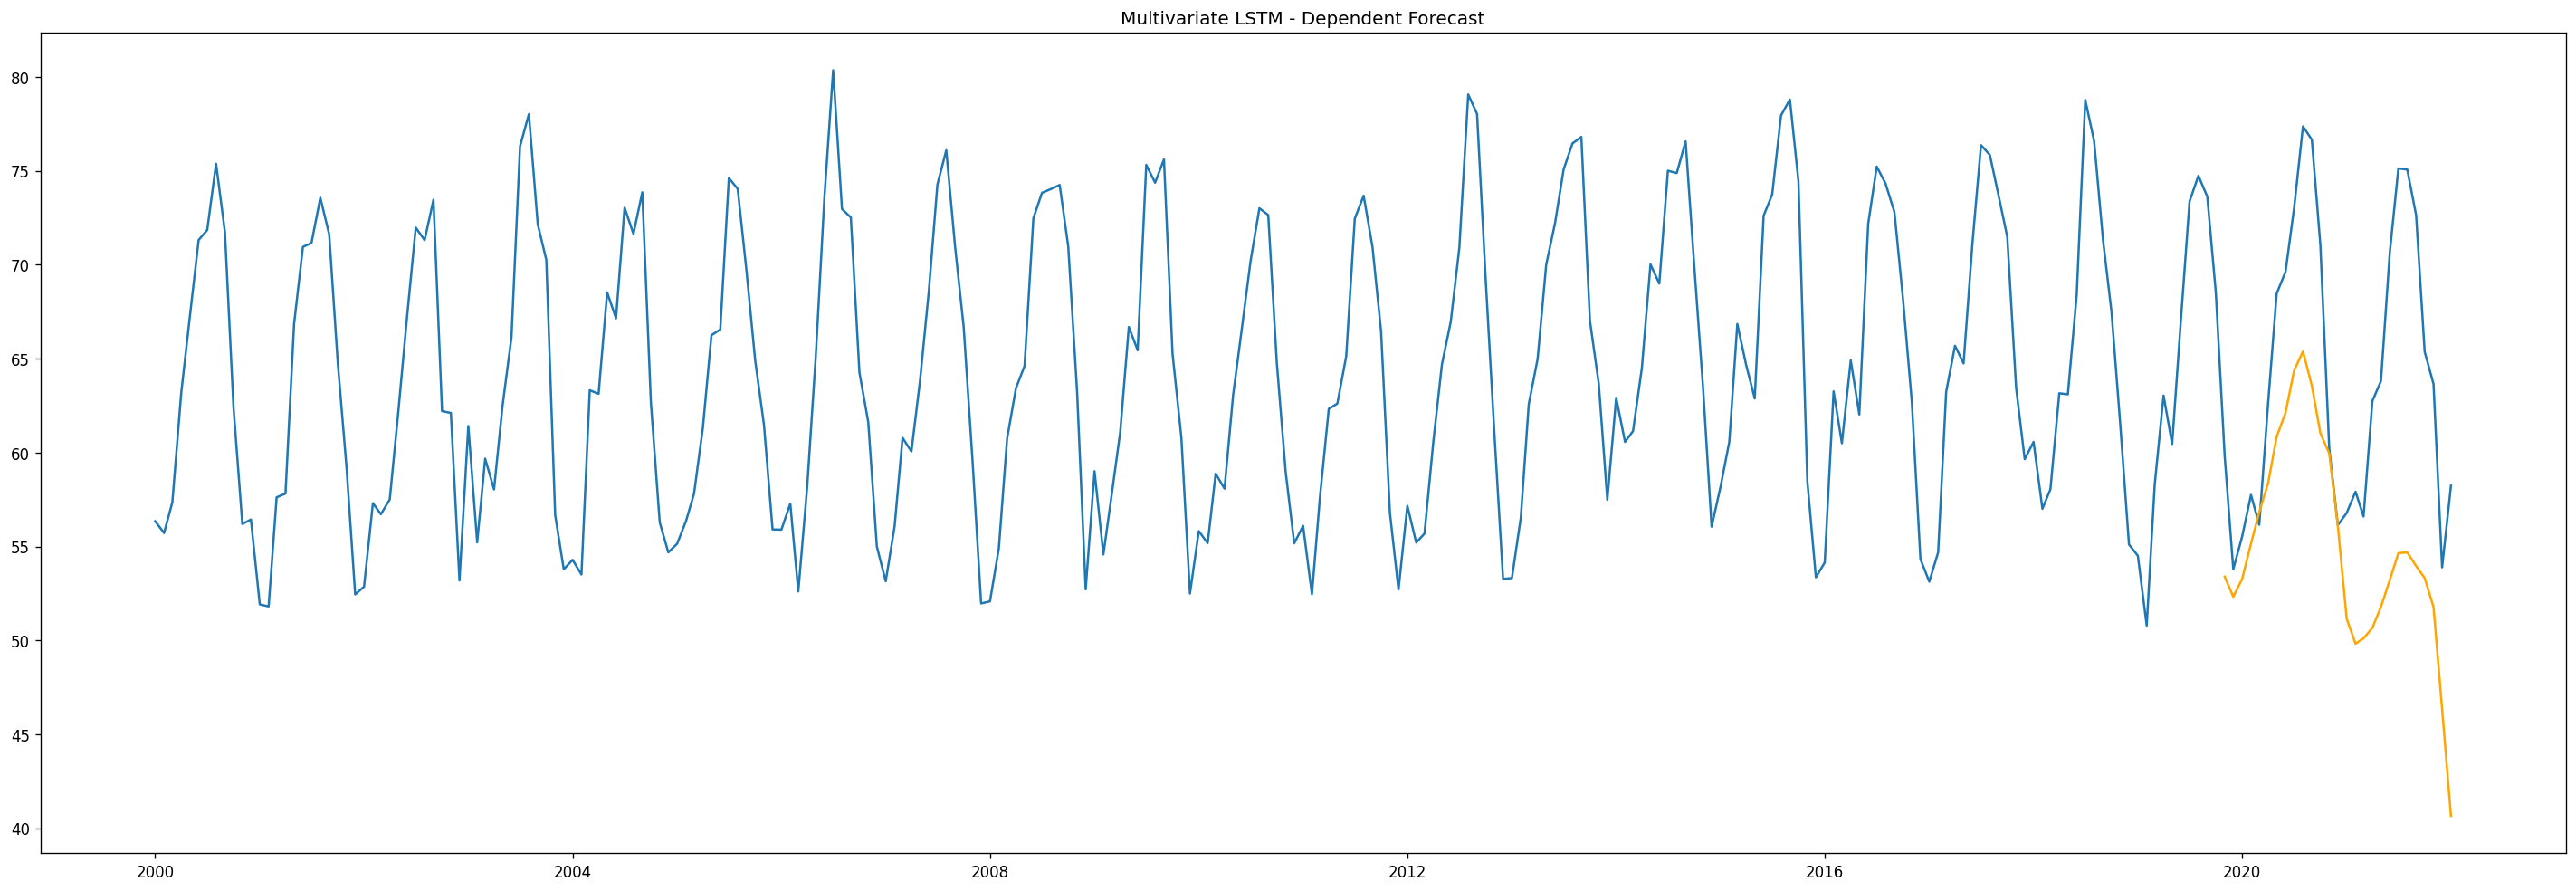

In [51]:
plt.figure(figsize=(30,10))
plt.plot(df['Avg Temperature (avg)'])
plt.plot(pd.Series(yhat_3[:,4], index=df_test.index), color='orange')

plt.title("Multivariate LSTM - Dependent Forecast")
plt.show()

In [52]:
multivar_dep_lstm_perf = pd.DataFrame({k:[v] for k, v in forecast_accuracy(yhat_3[:,4], y[:,4]).items()}).transpose().rename({0: 'Multivariate Dependent LSTM'}, axis=1)
multivar_dep_lstm_perf

,Multivariate Dependent LSTM
mape,0.137204
me,-9.104959
mae,9.154895
mpe,-0.136314
rmse,10.969023
acf1,0.729998
corr,0.602325
minmax,0.137198


# Comparison

In [53]:
all = pd.concat((arima_perf, auto_arima_perf, sarimax_perf, univar_ind_lstm_perf, univar_dep_lstm_perf, multivar_ind_lstm_perf, multivar_dep_lstm_perf), axis=1)

In [54]:
all

,ARIMA,Auto ARIMA,SARIMAX,Univar Independent LSTM,Univar Dependent LSTM,Multivariate Independent LSTM,Multivariate Dependent LSTM
mape,0.114125,0.043222,0.032494,0.044658,0.122977,0.090073,0.137204
me,1.960739,-0.152342,-0.715233,-2.553192,-8.016990,-5.683955,-9.104959
mae,7.104831,2.741863,2.063854,2.883681,8.016990,5.752948,9.154895
mpe,0.044651,0.002115,-0.010183,-0.038924,-0.122977,-0.088958,-0.136314
rmse,7.798503,3.288330,2.547939,3.353608,8.696145,6.944481,10.969023
acf1,0.786309,0.445669,-0.157668,-0.182469,0.551945,0.473308,0.729998
corr,0.050632,0.920306,0.946594,0.957988,0.899918,0.872320,0.602325
minmax,0.103371,0.041510,0.032138,0.044572,0.122977,0.090068,0.137198


In [55]:
all.abs().loc[["mape", "me", "mae", "mpe", "rmse"]].style.highlight_min(color = 'darkred', axis = 1)

,ARIMA,Auto ARIMA,SARIMAX,Univar Independent LSTM,Univar Dependent LSTM,Multivariate Independent LSTM,Multivariate Dependent LSTM
mape,0.114125,0.043222,0.032494,0.044658,0.122977,0.090073,0.137204
me,1.960739,0.152342,0.715233,2.553192,8.016990,5.683955,9.104959
mae,7.104831,2.741863,2.063854,2.883681,8.016990,5.752948,9.154895
mpe,0.044651,0.002115,0.010183,0.038924,0.122977,0.088958,0.136314
rmse,7.798503,3.288330,2.547939,3.353608,8.696145,6.944481,10.969023


In [56]:
all.abs().loc[["acf1", "corr", "minmax"]].style.highlight_max(color = 'darkred', axis = 1)

,ARIMA,Auto ARIMA,SARIMAX,Univar Independent LSTM,Univar Dependent LSTM,Multivariate Independent LSTM,Multivariate Dependent LSTM
acf1,0.786309,0.445669,0.157668,0.182469,0.551945,0.473308,0.729998
corr,0.050632,0.920306,0.946594,0.957988,0.899918,0.872320,0.602325
minmax,0.103371,0.041510,0.032138,0.044572,0.122977,0.090068,0.137198
